# Intro

This notebook will create:
- map of average winter sea ice extent in 2007 and 2015, overlaid with location of the polar front for DJF (show the square and make sure included in polar front)
- correlation based analysis: time series plot of: a) meridional SST gradient b) compared with the sea ice extent c) OHC for the whole timeseries
- AW temperature profile across the exit (Bear island trench) as a cross section for the two years
- WMT maps for the two series, try to identify BSW, AW, ArW
- M term as an average for the two sets of DJF values

# packages

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

In [19]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
# image path to save
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/BarentsS_paper/2007v2016/"

# define the Barents Sea mask (we will change later)

In [5]:
mskBarents = mskBasin[mskBasin == 6]

In [6]:
# also plot underneath this the average profiles
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

# define the timesteps we want to read from

In [7]:
# define the years of this that we want to read from
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2006"] = np.array([12])
times["2007"] = np.arange(1,4,1)


# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps # this is 3 for the 3 months we want to do the budget from

3

In [8]:
# define the years of this that we want to read from
fnames = get_fnames(dt_aste,startyr,endyr)

times2 = {}
times2["2013"] = np.array([12])
times2["2014"] = np.arange(1,4,1)


# the filenames we want for 2014
tsstr2,datetimes2 = get_tsteps(times2,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt2 = datetimes2[1]-datetimes2[0]   # days
dt2 = dt2.total_seconds()

tsteps2 = len(datetimes2)-1
tsteps2 # this is 3 for the 3 months we want to do the budget from

3

In [9]:
tsstr

array(['0000258480', '0000262944', '0000267408', '0000271440'],
      dtype='<U32')

In [10]:
tsstr2

array(['0000626688', '0000631152', '0000635616', '0000639648'],
      dtype='<U32')

# 2x2 -  SST gradient, sea ice extent for the two years
Why? 

Barton 2018 found PF steepened for less sea ice

Smedsrud 2013 found that increased AW heat transport led to reduced winter sea ice in Barents Sea

Onarheim and Arthun 2017 showed winter sea ice no longer extends south of PF in an Atlantified scenario

In [11]:
# load the SST for the two years

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
THETA = np.zeros((len(tsstr[:-1])+len(tsstr2[:-1]),nz,ny,nx))

#DJF 2007
for t in range(len(tsstr[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t] = THETAi

#DJF 2016
for t in range(len(tsstr2[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr2[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t+3] = THETAi

# do the time averaging
THETA1 = np.nanmean(THETA[:3],axis=0) #* hfC
THETA2 = np.nanmean(THETA[3:],axis=0) #* hfC

In [12]:
# load the sea ice

SIarea = np.zeros((len(tsstr[:-1])+len(tsstr2[:-1]),ny,nx))

# DJF for 2007
for t in range(len(tsstr[:-1])):
    file_name = 'budg2d_snap_set1'
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_snap_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    SIareai,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    SIareai = SIareai.reshape(ny,nx)

    # set in the larger array
    SIarea[t] = SIareai

# DJF for 2016
for t in range(len(tsstr2[:-1])):
    file_name = 'budg2d_snap_set1'
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_snap_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    t2 = int(tsstr2[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    SIareai,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    SIareai = SIareai.reshape(ny,nx)

    # set in the larger array
    SIarea[t+3] = SIareai

# do the time averaging
SIarea1 = np.nanmean(SIarea[:3],axis=0)
SIarea2 = np.nanmean(SIarea[3:],axis=0)

In [13]:
# check here the difference between the two
mymsk = np.zeros((1350,270))
idxs = np.where(mskBasin==6)
mymsk[idxs[0],idxs[1]] = 1

print(np.nansum(SIarea1 * mymsk))
print(np.nansum(SIarea2 * mymsk))

print(np.nansum(SIarea1))
print(np.nansum(SIarea2))

1122.9843662688063
1333.1037040373774
45660.99159351946
46037.561594065264


In [14]:
# plot SST gradient and sea ice area
DXG = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0]
DYG = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0]
SST1 = get_aste_tracer(np.nanmean(THETA1[:5],axis=0),nfx,nfy)[0] # top 50 m
SST2 = get_aste_tracer(np.nanmean(THETA2[:5],axis=0),nfx,nfy)[0] # top 50 m

SST1 = get_aste_tracer(THETA1,nfx,nfy)[0] # SST
SST2 = get_aste_tracer(THETA2,nfx,nfy)[0] # SST

In [15]:
# calculate the gradients for the two years
# first set
dTdx = np.zeros_like(SST1)
dTdx[:, 1:-1] = (SST1[:, 2:] - SST1[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])
# Compute central finite difference for dT/dy
dTdy = np.zeros_like(SST1)
dTdy[1:-1, :] = (SST1[2:, :] - SST1[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])
# Compute the magnitude of the SST gradient
grad_T = np.sqrt(dTdx**2 + dTdy**2)
mask = (SST1 > -2) & (SST1 < 4)  # Create mask for out-of-range values
grad_T_masked1 = grad_T * mask * 1000

# second set
dTdx = np.zeros_like(SST2)
dTdx[:, 1:-1] = (SST2[:, 2:] - SST2[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])
# Compute central finite difference for dT/dy
dTdy = np.zeros_like(SST1)
dTdy[1:-1, :] = (SST2[2:, :] - SST2[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])
# Compute the magnitude of the SST gradient
grad_T = np.sqrt(dTdx**2 + dTdy**2)
mask = (SST2 > -2) & (SST2 < 4)  # Create mask for out-of-range values
grad_T_masked2 = grad_T * mask

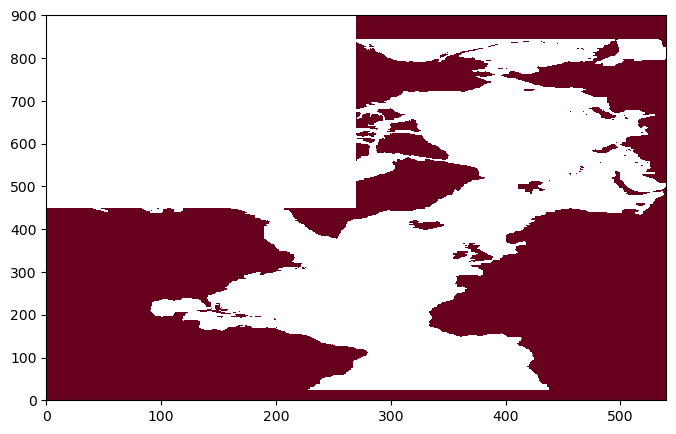

In [23]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

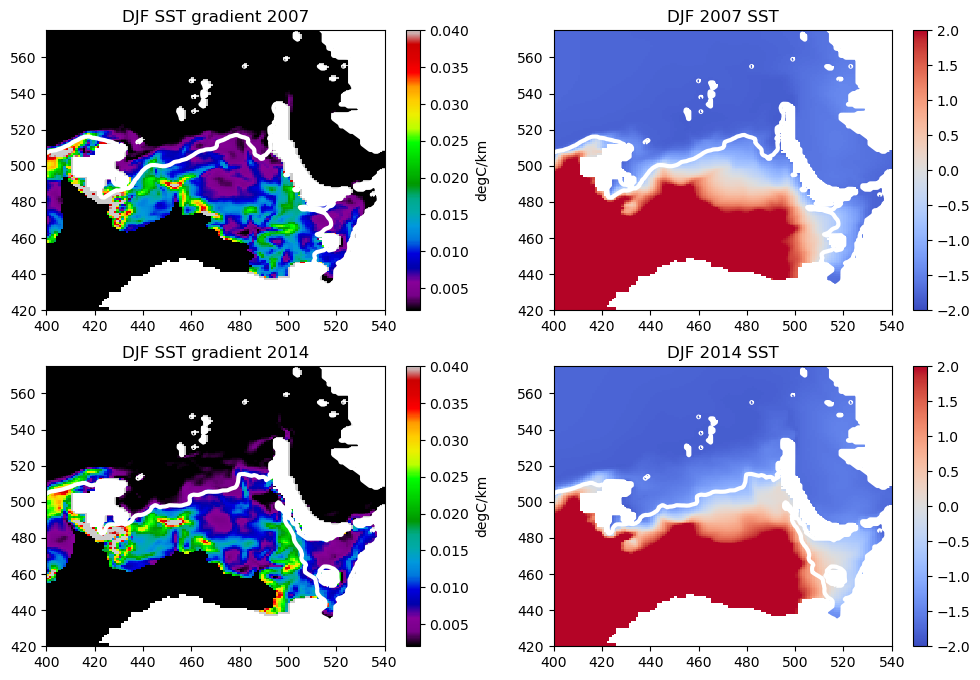

In [38]:
fig = plt.figure(figsize=(12,8))

vmin,vmax = 0.002,4e-2

############################################################
# 2007 DJF
ax = plt.subplot(221)
# Compute central finite difference for dT/dx

# grad_T.shape
cb = ax.pcolormesh(grad_T_masked1,cmap='nipy_spectral',vmin=vmin,vmax=vmax)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='Greys')
cs = ax.contour(get_aste_tracer(SIarea1,nfx,nfy)[0],levels=[thresh],colors="white",linewidths=3)
plt.colorbar(cb,label="degC/km")
ax.set_xlim(400,540)
ax.set_ylim(420,575)
ax.set_title("DJF SST gradient 2007")

ax = plt.subplot(222)
# grad_T.shape
cb = ax.pcolormesh(get_aste_tracer(THETA1,nfx,nfy)[0],vmin=-2,vmax=2,cmap='coolwarm')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='Greys')


# add the line for the ice edge at 15%
cs = ax.contour(get_aste_tracer(SIarea1,nfx,nfy)[0],levels=[thresh],colors="white",linewidths=3)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(420,575)
ax.set_title("DJF 2007 SST")

############################################################
# 2016 DJF
ax = plt.subplot(223)
# Compute central finite difference for dT/dx

# grad_T.shape
cb = ax.pcolormesh(grad_T_masked2*1000,cmap='nipy_spectral',vmin=vmin,vmax=vmax)
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='Greys')
cs = ax.contour(get_aste_tracer(SIarea2,nfx,nfy)[0],levels=[thresh],colors="white",linewidths=3)
plt.colorbar(cb,label="degC/km")
ax.set_xlim(400,540)
ax.set_ylim(420,575)
ax.set_title("DJF SST gradient 2014")

ax = plt.subplot(224)
# grad_T.shape
cb = ax.pcolormesh(get_aste_tracer(THETA2,nfx,nfy)[0],vmin=-2,vmax=2,cmap='coolwarm')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='Greys')
cs = ax.contour(get_aste_tracer(SIarea2,nfx,nfy)[0],levels=[thresh],colors="white",linewidths=3)

plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(420,575)
ax.set_title("DJF 2014 SST")

plt.savefig(path + "pf_comparson_reBarton_2007v2014.png",dpi=300)

# also look at the temperature of inflow for the two years

In [30]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

In [31]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)

In [32]:
# do a sample for the BSO
# get the distance from coast to coast from DXG and DYG
distance = np.array([])

# get the adv values
for i in range(len(x_bso)):
    thisy = y_bso[i]
    thisx = x_bso[i]
    this_choose = choose_UV_bso[i]

    if this_choose == 'H':
        distance = np.append(distance,(mygrid['DYG'][thisy,thisx]))
    else:
        distance = np.append(distance,(mygrid['DXG'][thisy,thisx]))

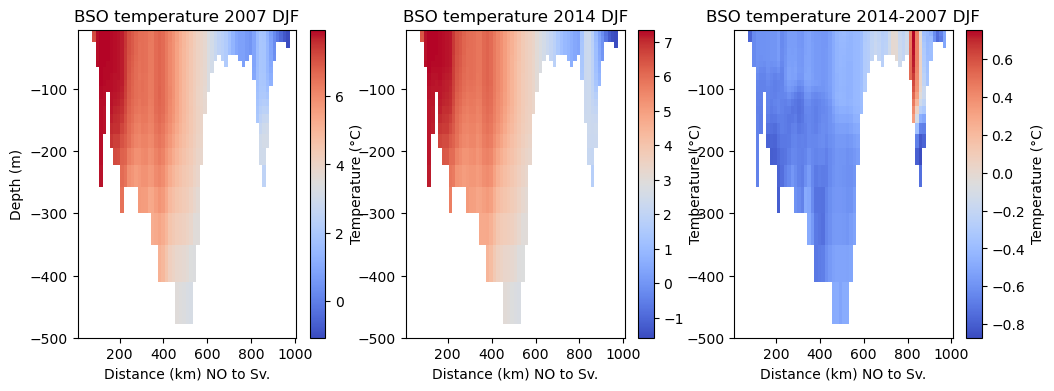

In [34]:

x = np.cumsum(distance/1000)
y = np.cumsum(-mygrid['DRF'])

# Mask out zeros by converting them to NaN
data = THETA1[:,y_bso,x_bso]
data_masked = np.where(data == 0, np.nan, data)  # Replace 0 with NaN

# Plot using pcolormesh
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(131)
cb = ax.pcolormesh(x, y, data_masked, cmap='coolwarm', shading='auto')  # Use shading='auto' for better alignment
plt.colorbar(cb, ax=ax, label="Temperature (°C)")
# plt.pcolormesh(data)
ax.set_ylim(-500,-5)
ax.set_xlabel("Distance (km) NO to Sv.")
ax.set_ylabel("Depth (m)")
ax.set_title("BSO temperature 2007 DJF")


ax = plt.subplot(132)
# Mask out zeros by converting them to NaN
data = THETA2[:,y_bso,x_bso]
data_masked = np.where(data == 0, np.nan, data)  # Replace 0 with NaN
cb = ax.pcolormesh(x, y, data_masked, cmap='coolwarm', shading='auto')  # Use shading='auto' for better alignment
plt.colorbar(cb, ax=ax, label="Temperature (°C)")
# plt.pcolormesh(data)
ax.set_ylim(-500,-5)
ax.set_xlabel("Distance (km) NO to Sv.")
# ax.set_ylabel("Depth (m)")
ax.set_title("BSO temperature 2014 DJF")


ax = plt.subplot(133)
# Mask out zeros by converting them to NaN
data = THETA2[:,y_bso,x_bso] - THETA1[:,y_bso,x_bso]
data_masked = np.where(data == 0, np.nan, data)  # Replace 0 with NaN
cb = ax.pcolormesh(x, y, data_masked, cmap='coolwarm', shading='auto')  # Use shading='auto' for better alignment
plt.colorbar(cb, ax=ax, label="Temperature (°C)")
# plt.pcolormesh(data)
ax.set_ylim(-500,-5)
ax.set_xlabel("Distance (km) NO to Sv.")
# ax.set_ylabel("Depth (m)")
ax.set_title("BSO temperature 2014-2007 DJF")

plt.savefig(path + "BSO_temperature_compare2007_2014.png",dpi=300)

# what is the actual Sea ice area difference between the two?

In [35]:
mymsk = np.zeros((1350,270))
idxs = np.where(mskBasin==6)
mymsk[idxs[0],idxs[1]] = 1

In [36]:
print(np.nansum(SIarea1 * mymsk))
print(np.nansum(SIarea2 * mymsk))

1122.9843662688063
1333.1037040373774


In [37]:
print(np.nansum(SIarea1))
print(np.nansum(SIarea2))

45660.99159351946
46037.561594065264


# define a new mask to look at the pf specifically

Some thoughts:
We want to determine the difference between the impact of inflow (this is not changing in the Barents Sea) a